In [4]:
#Pytorch
import torch
import torch.nn.functional as F
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
  
#Pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

#Image Processing
import matplotlib.pyplot as plt
from skimage import io, transform, color
import PIL
from PIL import Image

#Others
import sklearn.metrics
from sklearn.metrics import *
import numpy as np
import pandas as pd
import cv2
import time
import os
import copy
from model_summary import *
import pretrainedmodels
import tqdm
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

import dataloaders
from dataloaders import *

## Dataloader

class dataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):

        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.data_frame.iloc[idx]['name'])
        image = Image.open(img_name)

        label = self.data_frame.iloc[idx]['category']       

        if self.transform:
            image = self.transform(image)
    
        return {'image':image,'category':label,'name':self.data_frame.iloc[idx]['name']}
    

def get_dataloader(data_dir, train_csv_path, image_size, img_mean, img_std, batch_size=1):

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(image_size),#row to column ratio should be 1.69
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.5),
            transforms.RandomRotation(15),
            transforms.RandomAffine(translate=(0,0.2),degrees=15,shear=15),
            transforms.ToTensor(),
            transforms.Normalize(img_mean,img_std)
        ]),
        'valid': transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(img_mean,img_std)
        ]),
        'test': transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(img_mean,img_std)
        ])
    }

    image_datasets = {}
    dataloaders = {}
    dataset_sizes = {}

    for x in ['train', 'valid', 'test']:
        if x == 'test':
            bs = 1
            sh = False
        else:
            bs = batch_size
            sh = True
        image_datasets[x] = dataset(train_csv_path.replace('train',x),root_dir=data_dir,transform=data_transforms[x])
        dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=bs,shuffle=sh, num_workers=8)    
        dataset_sizes[x] = len(image_datasets[x])

    device = torch.device("cuda:0")

    return dataloaders,dataset_sizes,image_datasets,device

## Selector network (U-Net)

def build_selector():
    class unetConv2(nn.Module):
        def __init__(self, in_size, out_size, is_batchnorm):
            super(unetConv2, self).__init__()

            if is_batchnorm:
                self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 1),
                                           nn.BatchNorm2d(out_size),
                                           nn.ReLU(),)
                self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, 3, 1, 1),
                                           nn.BatchNorm2d(out_size),
                                           nn.ReLU(),)
            else:
                self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 1),
                                           nn.ReLU(),)
                self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, 3, 1, 1),
                                           nn.ReLU(),)
        def forward(self, inputs):
            outputs = self.conv1(inputs)
            outputs = self.conv2(outputs)
            return outputs

    class unetUp(nn.Module):
        def __init__(self, in_size, out_size, is_deconv):
            super(unetUp, self).__init__()
            self.conv = unetConv2(in_size, out_size, False)
            if is_deconv:
                self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
            else:
                self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        def forward(self, inputs1, inputs2):
            outputs2 = self.up(inputs2)
            offset = outputs2.size()[2] - inputs1.size()[2]
            padding = 2 * [offset // 2, offset // 2]
            outputs1 = F.pad(inputs1, padding)
            return self.conv(torch.cat([outputs1, outputs2], 1))

    class unet(nn.Module):

        def __init__(self, feature_scale=4, n_classes=1, is_deconv=True, in_channels=3, is_batchnorm=True):
            super(unet, self).__init__()
            self.is_deconv = is_deconv
            self.in_channels = in_channels
            self.is_batchnorm = is_batchnorm
            self.feature_scale = feature_scale

            filters = [32, 64, 128, 256, 512]
            filters = [int(x / self.feature_scale) for x in filters]

            #downsampling
            self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
            self.maxpool1 = nn.MaxPool2d(kernel_size=2)

            self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
            self.maxpool2 = nn.MaxPool2d(kernel_size=2)

            self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
            self.maxpool3 = nn.MaxPool2d(kernel_size=2)

            self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
            self.maxpool4 = nn.MaxPool2d(kernel_size=2)
                    
            self.center = unetConv2(filters[3], filters[4], self.is_batchnorm)

            # upsampling
            self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv)
            self.up_concat3 = unetUp(filters[3], filters[2], self.is_deconv)
            self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv)
            self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv)

            # final conv (without any concat)
            self.final = nn.Conv2d(filters[4], n_classes, 1)

        def forward(self, inputs):
            conv1 = self.conv1(inputs)
            maxpool1 = self.maxpool1(conv1)

            conv2 = self.conv2(maxpool1)
            maxpool2 = self.maxpool2(conv2)

            conv3 = self.conv3(maxpool2)
            maxpool3 = self.maxpool3(conv3)

            conv4 = self.conv4(maxpool3)
            maxpool4 = self.maxpool4(conv4)

            center = self.center(maxpool4)
            #up4 = self.up_concat4(conv4, center)
            #up3 = self.up_concat3(conv3, up4)
            #up2 = self.up_concat2(conv2, up3)
            #up1 = self.up_concat1(conv1, up2)

            final = self.final(center)

            return final
        
    model = unet()
    return model

a = build_selector()

#summary(a.cuda(),(3,224,224))

## Predictor-Discriminator-Baseline

def build_pdb():

    class mdl(nn.Module):
        def __init__(self,base_model):
            super().__init__()
            self.base = base_model 
            self.gap = nn.AdaptiveAvgPool2d((1,1))
            self.fc1 = nn.Linear(512,2)

        def forward(self, x):
            x_base = self.base(x)
            x = self.gap(x_base)
            x = x.view(x.size(0), -1)
            x = self.fc1(x)
            return x,x_base 

    v = models.vgg16_bn(pretrained=True)
    v1 = nn.Sequential(*list(v.children())[:-1])

    #r = models.resnet101(pretrained=True)
    #r1 = nn.Sequential(*list(r.children())[:-2])
    
    model = mdl(v1[-1][:-1])
    model.load_state_dict(torch.load('Weights/grad_cam_vgg_16_dogcat.pt'))
        
    return model
    

## Sampler

def sampler(gen_prob):

    # Sampling
    samples = np.random.binomial(1, gen_prob, gen_prob.shape)

    return samples

def test_samples(gen_prob):
    out = torch.zeros(gen_prob.shape)
    out[gen_prob>0.5] = 1
    return out

## Mask generation

class get_prob_mask(torch.nn.Module):
    def __init__(self,img_size,patch_size):
        super(get_prob_mask, self).__init__()
        self.i_h = img_size[0]
        self.i_w = img_size[1]
        self.p_h = patch_size[0]
        self.p_w = patch_size[1]
        
    def forward(self,x):
        b,c,h,w = x.size()
        mask = torch.zeros((b,c,self.i_h,self.i_w))
        for i in range(h):
            for j in range(w):
                mask[0][0][i*self.p_h:(i+1)*self.p_h,j*self.p_w:(j+1)*self.p_w] = x[0][0][i,j]
                #import pdb;pdb.set_trace()
        return mask
    

## DC-INVASE class

class dc_invase():
    def __init__(self):
        
        #Initialization
        self.data_dir = '../Data/DogCat/train/'
        self.train_csv = '../CSV/dogcat_train_1.csv'
        self.num_epochs = 50
        self.input_shape = (224,224)
        self.patch_shape = (16,16)
        self.batch_size = 1
        self.img_mean = [0,0,0]#[0.485, 0.456, 0.406]
        self.img_std = [1,1,1]#[0.229, 0.224, 0.225]
        self.alpha = 0.5
        self.beta = 0.05
        self.exp_name = 'Weights/dci_dc_pdb_wo_sig'
        
        #Define the three models
        self.selector = build_selector()
        self.predictor = build_pdb()
        self.discriminator = build_pdb()
        self.baseline = build_pdb()
        
        
        #Put them on the GPU
        self.selector = self.selector.cuda()
        self.predictor = self.predictor.cuda()
        self.discriminator = self.discriminator.cuda()
        self.baseline = self.baseline.cuda()
        
        #Get the dataloaders
        self.dataloaders,self.dataset_sizes,self.dataset,self.device = get_dataloader(self.data_dir,self.train_csv,\
                                                        self.input_shape,self.img_mean,self.img_std,self.batch_size)
        
        #Define the three optimizers one for each model
        self.optimizer_sel = optim.Adam(self.selector.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.optimizer_pred = optim.Adam(self.predictor.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.optimizer_dis = optim.Adam(self.discriminator.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.optimizer_base = optim.Adam(self.baseline.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

        #Loss to ensure sparsity
        self.l1_loss = nn.L1Loss()
        
        self.prob_mask = get_prob_mask(self.input_shape,self.patch_shape)
        
        
        
    def train(self):
        
        since = time.time()
        best_sel_loss = 0

        for epoch in range(self.num_epochs):
            print('Epoch {}/{}'.format(epoch, self.num_epochs - 1),flush=True)
            print('-' * 10,flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    
                    #Set the models to training mode
                    self.predictor.train() 
                    self.discriminator.train()
                    self.selector.train()
                    self.baseline.train()
                
                else:
                    #Set the models to evaluation mode
                    self.predictor.eval()
                    self.discriminator.eval()
                    self.selector.eval()
                    self.baseline.eval()
                    
                #Keep a track of all the three loss
                running_sel_loss = 0.0
                running_pred_loss = 0.0
                running_dis_loss = 0.0
                running_base_loss = 0.0
                running_spa = 0.0

                
                #Metrics : accuracy
                running_pred_acc = 0
                running_dis_acc = 0
                running_base_acc = 0

                #tqdm bar
                pbar = tqdm(total=self.dataset_sizes[phase])

                # Iterate over data.
                for sampled_batch in self.dataloaders[phase]:

                    inputs = sampled_batch['image']
                    labels = sampled_batch['category']
                    
                    #Input needs to be float and labels long
                    inputs = inputs.float().to(self.device)
                    labels = labels.long().to(self.device)

                    # zero the parameter gradients
                    self.optimizer_sel.zero_grad()
                    self.optimizer_pred.zero_grad()
                    self.optimizer_dis.zero_grad()
                    self.optimizer_base.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        
                        #import pdb;pdb.set_trace()
                    
                        #Generate selection probabilites using selector function. This will be the mask
                        #sel_prob = F.sigmoid(self.selector(inputs))
                        sel_prob = self.selector(inputs)
                        sel_prob = sel_prob - sel_prob.min()
                        sel_prob = sel_prob/sel_prob.max()
                        
                        bin_samples = sampler(sel_prob.data.cpu().numpy())
                        bin_samples = torch.Tensor(bin_samples).to(self.device)
                        bin_mask = self.prob_mask(bin_samples).to(self.device)
                    
                        #Compute the Complementary selection probability
                        comp_bin_mask = 1 - bin_mask
                        
                        #Generate X_S the selection probability masked image
                        x_s = inputs*bin_mask
                        
                        #Generate X_S_bar the complementary selection probability masked image
                        x_s_bar = inputs*comp_bin_mask
                        
                        #Generate predictor output probabilities
                        base_out,_ = self.baseline(inputs)
                        base_prob = F.softmax(base_out)
                        _, base_preds = torch.max(base_out, 1)
                        
                        #Generate predictor output probabilities
                        pred_out,_ = self.predictor(x_s)
                        pred_prob = F.softmax(pred_out)
                        _, pred_preds = torch.max(pred_out, 1)
                        
                        #Generate discriminator probabilities)
                        dis_out,_ = self.discriminator(x_s_bar)
                        dis_prob = F.softmax(dis_out)
                        _, dis_preds = torch.max(dis_out, 1)
                        
                        #Baseline Cross entropy
                        base_ce_loss = F.cross_entropy(base_out,labels)
                        
                        #Predictor Cross entropy
                        pred_ce_loss = F.cross_entropy(pred_out,labels)
                        
                        #Discriminator Negative Cross entropy
                        #dis_ce_loss = F.cross_entropy(dis_out,1-labels)
                        #import pdb;pdb.set_trace()
                        dis_ce_loss = dis_prob[0][int(labels[0])]
                        
                        #first KL divergence term
                        kl_1 = -base_ce_loss + pred_ce_loss
                        
                        #second KL divergence term
                        kl_2 = -base_ce_loss + dis_ce_loss
                        
                        #the difference in the two KL divergence terms
                        kl_diff = kl_1 - self.alpha*kl_2
                        kl_diff.detach()
                        
                        #Selector function loss
                        l1_loss = self.l1_loss(sel_prob,torch.zeros(sel_prob.shape,requires_grad=False).to(self.device))
                        
                        #kl_1.requires_grad = False
                        #kl_2.requires_grad = False
                        #kl_diff.requires_grad = False
                        
                        distribution_loss = torch.mean(bin_samples*torch.log(sel_prob + 1e-8) + (1-bin_samples)*torch.log(1 - sel_prob + 1e-8))
                        
                        sel_loss = distribution_loss*kl_diff + self.beta*l1_loss
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            
                            #The gradients of pred_ce_loss should not update the params of disc or sel
                            base_ce_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_dis.zero_grad()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_base.step()
                            
                            #Update predictor using pred_ce_loss
                            #The gradients of pred_ce_loss should not update the params of disc or sel
                            pred_ce_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_dis.zero_grad()
                            self.optimizer_base.zero_grad()
                            self.optimizer_pred.step()
                            
                            #The gradients of dis_ce_loss should not update the params of pred or sel
                            dis_ce_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_base.zero_grad()
                            self.optimizer_dis.step()
                            
                            #Update sel
                            sel_loss.backward()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_dis.zero_grad()
                            self.optimizer_base.zero_grad()
                            self.optimizer_sel.step()
                                    
                    # statistics
                    running_sel_loss += sel_loss.item() * inputs.size(0)
                    running_pred_loss += pred_ce_loss.item() * inputs.size(0)
                    running_dis_loss += dis_ce_loss.item() * inputs.size(0)
                    running_base_loss += base_ce_loss.item() * inputs.size(0)
                    running_spa += l1_loss.item() *inputs.size(0)
                
                    running_pred_acc += torch.sum(pred_preds == labels.data)
                    running_dis_acc += torch.sum(dis_preds == (1-labels.data))
                    running_base_acc += torch.sum(base_preds == labels.data)
                    
                    pbar.update(inputs.shape[0])
                pbar.close()

                epoch_base_loss = running_base_loss / self.dataset_sizes[phase]
                epoch_sel_loss = running_sel_loss / self.dataset_sizes[phase]
                epoch_pred_loss = running_pred_loss / self.dataset_sizes[phase]
                epoch_dis_loss = running_dis_loss / self.dataset_sizes[phase]
                epoch_spa = running_spa / self.dataset_sizes[phase]
                
                epoch_base_acc = running_base_acc.double()/ self.dataset_sizes[phase]
                epoch_pred_acc = running_pred_acc.double() / self.dataset_sizes[phase]
                epoch_dis_acc = running_dis_acc.double() / self.dataset_sizes[phase]

                print('{} Base_Loss: {:.4f} Sel_Loss: {:.4f} Pred_Loss: {:.4f} Dis_Loss: {:.4f} Spa: {:.4f} BAC: {:.4f} PAC: {:.4f} DAC: {:.4f}'.format(
                    phase, epoch_base_loss, epoch_sel_loss, epoch_pred_loss, epoch_dis_loss, epoch_spa, epoch_base_acc, epoch_pred_acc, epoch_dis_acc))

                # deep copy the model
                if phase == 'valid' and epoch_sel_loss < best_sel_loss:
                    
                    best_sel_loss = epoch_sel_loss
                    torch.save(self.selector.state_dict(),self.exp_name+'_sel.pt')
                    torch.save(self.baseline.state_dict(),self.exp_name+'_base.pt')
                    torch.save(self.predictor.state_dict(),self.exp_name+'_pred.pt')
                    torch.save(self.discriminator.state_dict(),self.exp_name+'_dis.pt')
                    #import pdb;pdb.set_trace()


        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best Sel Loss: {:4f}'.format(best_sel_loss))

        torch.save(self.baseline.state_dict(),self.exp_name+'_base_final.pt')
        torch.save(self.selector.state_dict(),self.exp_name+'_sel_final.pt')
        torch.save(self.predictor.state_dict(),self.exp_name+'_pred_final.pt')
        torch.save(self.discriminator.state_dict(),self.exp_name+'_dis_final.pt')

        print('Training completed finally !!!!!')
        
    def get_cam(self):
                
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.selector.eval()
        
        acc = 0
        total = 0
        mode = 'test'

        cm = []
        m = []
        bm = []
        
        params = list(self.selector.parameters())                        
        weight_softmax = torch.squeeze(params[-2].data)
        
        iou = 0
        
        with torch.no_grad():
            
            pbar = tqdm(total=self.dataset_sizes[mode])
            for data in self.dataloaders[mode]:

                inputs = data['image']
                labels = data['category']

                inputs = inputs.to(self.device)
                labels = labels.to(self.device) 
                
                sel_prob = self.selector(inputs)
                sel_prob = sel_prob - sel_prob.min()
                sel_prob = sel_prob/sel_prob.max()

                bin_samples = test_samples(sel_prob.data)
                bin_samples = torch.Tensor(bin_samples).to(self.device)
                bin_mask = self.prob_mask(bin_samples).to(self.device) 

                base_path = '../Experiments/Sanity_Check/'
                name = data['name'][0]

                #heatmap = cv2.applyColorMap(np.uint8(255*bin_mask.cpu().numpy().squeeze()), cv2.COLORMAP_JET)
                heatmap = bin_mask.cpu().numpy().squeeze()
                heatmap = np.expand_dims(heatmap,axis=2)
                #heatmap = np.float32(heatmap) / 255
                cam_f = heatmap*np.float32(inputs.cpu().numpy().squeeze().transpose((1,2,0)))
                cam_f = cam_f / np.max(cam_f)
                #cam_f = heatmap
                pr = name.replace('.j','_bin_16x16_wo_best.j')
                cv2.imwrite(base_path+pr,cam_f*255)

                
                pbar.update(inputs.shape[0])
                
            pbar.close()
        

    def return_model(self):
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.selector.eval()
        return self.selector,self.dataloaders['valid']


In [5]:
dci = dc_invase()

In [3]:
dci.train()

Epoch 0/49
----------



train Base_Loss: 0.2136 Sel_Loss: -0.0859 Pred_Loss: 0.6277 Dis_Loss: 0.5165 Spa: 0.1892 BAC: 0.9660 PAC: 0.6547 DAC: 0.4387



valid Base_Loss: 0.0553 Sel_Loss: -0.9194 Pred_Loss: 2.2481 Dis_Loss: 0.7062 Spa: 0.2227 BAC: 0.9820 PAC: 0.6660 DAC: 0.2880
Epoch 1/49
----------



train Base_Loss: 0.1135 Sel_Loss: -0.0873 Pred_Loss: 0.6219 Dis_Loss: 0.4225 Spa: 0.1161 BAC: 0.9727 PAC: 0.6540 DAC: 0.6380



valid Base_Loss: 0.0580 Sel_Loss: -0.5623 Pred_Loss: 1.8221 Dis_Loss: 0.6661 Spa: 0.1670 BAC: 0.9820 PAC: 0.6520 DAC: 0.3120
Epoch 2/49
----------



train Base_Loss: 0.0774 Sel_Loss: -0.0991 Pred_Loss: 0.6168 Dis_Loss: 0.2260 Spa: 0.0965 BAC: 0.9840 PAC: 0.6527 DAC: 0.8560



valid Base_Loss: 0.0805 Sel_Loss: -0.7437 Pred_Loss: 2.1238 Dis_Loss: 0.5506 Spa: 0.1948 BAC: 0.9720 PAC: 0.6120 DAC: 0.4440
Epoch 3/49
----------



train Base_Loss: 0.0486 Sel_Loss: -0.1012 Pred_Loss: 0.6149 Dis_Loss: 0.1309 Spa: 0.0848 BAC: 0.9913 PAC: 0.6473 DAC: 0.9260



valid Base_Loss: 0.0688 Sel_Loss: -0.4429 Pred_Loss: 1.2597 Dis_Loss: 0.4113 Spa: 0.2340 BAC: 0.9720 PAC: 0.6400 DAC: 0.5900
Epoch 4/49
----------



train Base_Loss: 0.0409 Sel_Loss: -0.0986 Pred_Loss: 0.6150 Dis_Loss: 0.0916 Spa: 0.0781 BAC: 0.9900 PAC: 0.6593 DAC: 0.9440



valid Base_Loss: 0.0499 Sel_Loss: -0.7463 Pred_Loss: 1.9188 Dis_Loss: 0.3536 Spa: 0.1985 BAC: 0.9860 PAC: 0.6460 DAC: 0.5000
Epoch 5/49
----------



train Base_Loss: 0.0402 Sel_Loss: -0.0919 Pred_Loss: 0.6179 Dis_Loss: 0.0703 Spa: 0.0732 BAC: 0.9907 PAC: 0.6440 DAC: 0.9527



valid Base_Loss: 0.0410 Sel_Loss: -0.9308 Pred_Loss: 2.3170 Dis_Loss: 0.3701 Spa: 0.2307 BAC: 0.9860 PAC: 0.6300 DAC: 0.5320
Epoch 6/49
----------



train Base_Loss: 0.0314 Sel_Loss: -0.0881 Pred_Loss: 0.6102 Dis_Loss: 0.0522 Spa: 0.0687 BAC: 0.9913 PAC: 0.6500 DAC: 0.9687



valid Base_Loss: 0.0468 Sel_Loss: -0.5867 Pred_Loss: 1.7630 Dis_Loss: 0.3460 Spa: 0.1523 BAC: 0.9800 PAC: 0.6340 DAC: 0.5540
Epoch 7/49
----------



train Base_Loss: 0.0390 Sel_Loss: -0.0884 Pred_Loss: 0.6050 Dis_Loss: 0.0433 Spa: 0.0686 BAC: 0.9893 PAC: 0.6513 DAC: 0.9753



valid Base_Loss: 0.0332 Sel_Loss: -0.7548 Pred_Loss: 2.1100 Dis_Loss: 0.3431 Spa: 0.1589 BAC: 0.9820 PAC: 0.5760 DAC: 0.5360
Epoch 8/49
----------



train Base_Loss: 0.0269 Sel_Loss: -0.0825 Pred_Loss: 0.6122 Dis_Loss: 0.0394 Spa: 0.0613 BAC: 0.9913 PAC: 0.6487 DAC: 0.9733



valid Base_Loss: 0.0299 Sel_Loss: -0.9238 Pred_Loss: 2.4488 Dis_Loss: 0.3498 Spa: 0.1770 BAC: 0.9900 PAC: 0.5580 DAC: 0.4980
Epoch 9/49
----------



train Base_Loss: 0.0283 Sel_Loss: -0.0782 Pred_Loss: 0.6093 Dis_Loss: 0.0349 Spa: 0.0599 BAC: 0.9907 PAC: 0.6767 DAC: 0.9740



valid Base_Loss: 0.0378 Sel_Loss: -0.9044 Pred_Loss: 2.3019 Dis_Loss: 0.3859 Spa: 0.2095 BAC: 0.9860 PAC: 0.6340 DAC: 0.5140
Epoch 10/49
----------



train Base_Loss: 0.0249 Sel_Loss: -0.0781 Pred_Loss: 0.5882 Dis_Loss: 0.0331 Spa: 0.0602 BAC: 0.9933 PAC: 0.6780 DAC: 0.9760



valid Base_Loss: 0.0394 Sel_Loss: -1.3271 Pred_Loss: 3.2062 Dis_Loss: 0.3197 Spa: 0.1837 BAC: 0.9860 PAC: 0.5960 DAC: 0.5480
Epoch 11/49
----------



train Base_Loss: 0.0223 Sel_Loss: -0.0709 Pred_Loss: 0.5991 Dis_Loss: 0.0256 Spa: 0.0558 BAC: 0.9953 PAC: 0.6653 DAC: 0.9820



valid Base_Loss: 0.0328 Sel_Loss: -1.5603 Pred_Loss: 3.9991 Dis_Loss: 0.3406 Spa: 0.1763 BAC: 0.9940 PAC: 0.6260 DAC: 0.5640
Epoch 12/49
----------



train Base_Loss: 0.0203 Sel_Loss: -0.0713 Pred_Loss: 0.5998 Dis_Loss: 0.0273 Spa: 0.0546 BAC: 0.9927 PAC: 0.6693 DAC: 0.9767



valid Base_Loss: 0.0452 Sel_Loss: -1.3397 Pred_Loss: 4.0625 Dis_Loss: 0.3745 Spa: 0.1453 BAC: 0.9820 PAC: 0.5980 DAC: 0.5520
Epoch 13/49
----------



train Base_Loss: 0.0167 Sel_Loss: -0.0674 Pred_Loss: 0.5838 Dis_Loss: 0.0206 Spa: 0.0534 BAC: 0.9967 PAC: 0.6947 DAC: 0.9867



valid Base_Loss: 0.0680 Sel_Loss: -0.5925 Pred_Loss: 2.2576 Dis_Loss: 0.2938 Spa: 0.1249 BAC: 0.9760 PAC: 0.6660 DAC: 0.6080
Epoch 14/49
----------



train Base_Loss: 0.0190 Sel_Loss: -0.0693 Pred_Loss: 0.6001 Dis_Loss: 0.0203 Spa: 0.0533 BAC: 0.9927 PAC: 0.6673 DAC: 0.9853



valid Base_Loss: 0.0438 Sel_Loss: -1.6204 Pred_Loss: 4.4091 Dis_Loss: 0.3076 Spa: 0.1324 BAC: 0.9860 PAC: 0.6100 DAC: 0.5600
Epoch 15/49
----------



train Base_Loss: 0.0180 Sel_Loss: -0.0665 Pred_Loss: 0.5826 Dis_Loss: 0.0175 Spa: 0.0520 BAC: 0.9967 PAC: 0.6673 DAC: 0.9840



valid Base_Loss: 0.0505 Sel_Loss: -1.3960 Pred_Loss: 4.2028 Dis_Loss: 0.3373 Spa: 0.1253 BAC: 0.9720 PAC: 0.5860 DAC: 0.6200
Epoch 16/49
----------



train Base_Loss: 0.0199 Sel_Loss: -0.0644 Pred_Loss: 0.5998 Dis_Loss: 0.0283 Spa: 0.0487 BAC: 0.9933 PAC: 0.6620 DAC: 0.9740



valid Base_Loss: 0.0368 Sel_Loss: -1.1465 Pred_Loss: 3.0399 Dis_Loss: 0.3229 Spa: 0.2335 BAC: 0.9860 PAC: 0.6320 DAC: 0.6000
Epoch 17/49
----------



train Base_Loss: 0.0181 Sel_Loss: -0.0641 Pred_Loss: 0.5925 Dis_Loss: 0.0181 Spa: 0.0481 BAC: 0.9947 PAC: 0.6680 DAC: 0.9860



valid Base_Loss: 0.0434 Sel_Loss: -0.9088 Pred_Loss: 2.4947 Dis_Loss: 0.2924 Spa: 0.1983 BAC: 0.9840 PAC: 0.6440 DAC: 0.6220
Epoch 18/49
----------



train Base_Loss: 0.0173 Sel_Loss: -0.0619 Pred_Loss: 0.5899 Dis_Loss: 0.0115 Spa: 0.0472 BAC: 0.9920 PAC: 0.6713 DAC: 0.9913



valid Base_Loss: 0.0421 Sel_Loss: -2.6522 Pred_Loss: 5.7182 Dis_Loss: 0.3332 Spa: 0.2615 BAC: 0.9720 PAC: 0.5660 DAC: 0.5660
Epoch 19/49
----------



train Base_Loss: 0.0244 Sel_Loss: -0.0642 Pred_Loss: 0.5849 Dis_Loss: 0.0175 Spa: 0.0483 BAC: 0.9920 PAC: 0.6893 DAC: 0.9860



valid Base_Loss: 0.0312 Sel_Loss: -1.2910 Pred_Loss: 3.7468 Dis_Loss: 0.2746 Spa: 0.1552 BAC: 0.9900 PAC: 0.6340 DAC: 0.7580
Epoch 20/49
----------



train Base_Loss: 0.0126 Sel_Loss: -0.0587 Pred_Loss: 0.5941 Dis_Loss: 0.0175 Spa: 0.0442 BAC: 0.9960 PAC: 0.6720 DAC: 0.9840



valid Base_Loss: 0.0405 Sel_Loss: -1.7590 Pred_Loss: 5.4133 Dis_Loss: 0.2840 Spa: 0.1337 BAC: 0.9860 PAC: 0.6020 DAC: 0.6200
Epoch 21/49
----------



train Base_Loss: 0.0099 Sel_Loss: -0.0599 Pred_Loss: 0.5972 Dis_Loss: 0.0161 Spa: 0.0437 BAC: 0.9987 PAC: 0.6620 DAC: 0.9860



valid Base_Loss: 0.0459 Sel_Loss: -1.8770 Pred_Loss: 4.0259 Dis_Loss: 0.2978 Spa: 0.2286 BAC: 0.9820 PAC: 0.5720 DAC: 0.6140
Epoch 22/49
----------



train Base_Loss: 0.0139 Sel_Loss: -0.0577 Pred_Loss: 0.5925 Dis_Loss: 0.0140 Spa: 0.0438 BAC: 0.9960 PAC: 0.6780 DAC: 0.9880



valid Base_Loss: 0.0866 Sel_Loss: -4.8351 Pred_Loss: 9.9195 Dis_Loss: 0.3094 Spa: 0.2185 BAC: 0.9660 PAC: 0.6040 DAC: 0.6620
Epoch 23/49
----------



train Base_Loss: 0.0091 Sel_Loss: -0.0573 Pred_Loss: 0.5820 Dis_Loss: 0.0137 Spa: 0.0438 BAC: 0.9973 PAC: 0.6720 DAC: 0.9893



valid Base_Loss: 0.0509 Sel_Loss: -3.7209 Pred_Loss: 8.6245 Dis_Loss: 0.2941 Spa: 0.1676 BAC: 0.9880 PAC: 0.5640 DAC: 0.7160
Epoch 24/49
----------



train Base_Loss: 0.0143 Sel_Loss: -0.0526 Pred_Loss: 0.5944 Dis_Loss: 0.0141 Spa: 0.0406 BAC: 0.9960 PAC: 0.6700 DAC: 0.9893



valid Base_Loss: 0.0648 Sel_Loss: -3.2246 Pred_Loss: 7.7306 Dis_Loss: 0.2983 Spa: 0.1472 BAC: 0.9600 PAC: 0.5580 DAC: 0.6120
Epoch 25/49
----------



train Base_Loss: 0.0223 Sel_Loss: -0.0499 Pred_Loss: 0.5920 Dis_Loss: 0.0122 Spa: 0.0391 BAC: 0.9940 PAC: 0.6720 DAC: 0.9907



valid Base_Loss: 0.0367 Sel_Loss: -1.6350 Pred_Loss: 4.3278 Dis_Loss: 0.2765 Spa: 0.1481 BAC: 0.9860 PAC: 0.5640 DAC: 0.5940
Epoch 26/49
----------



train Base_Loss: 0.0040 Sel_Loss: -0.0610 Pred_Loss: 0.5832 Dis_Loss: 0.0119 Spa: 0.0453 BAC: 1.0000 PAC: 0.6860 DAC: 0.9907



valid Base_Loss: 0.0658 Sel_Loss: -2.9988 Pred_Loss: 6.5434 Dis_Loss: 0.3123 Spa: 0.2115 BAC: 0.9640 PAC: 0.6220 DAC: 0.6680
Epoch 27/49
----------



train Base_Loss: 0.0133 Sel_Loss: -0.0509 Pred_Loss: 0.5840 Dis_Loss: 0.0110 Spa: 0.0398 BAC: 0.9960 PAC: 0.6847 DAC: 0.9900



valid Base_Loss: 0.0454 Sel_Loss: -1.5964 Pred_Loss: 4.2670 Dis_Loss: 0.2942 Spa: 0.1911 BAC: 0.9800 PAC: 0.5860 DAC: 0.6300
Epoch 28/49
----------



train Base_Loss: 0.0115 Sel_Loss: -0.0499 Pred_Loss: 0.5808 Dis_Loss: 0.0097 Spa: 0.0392 BAC: 0.9967 PAC: 0.6827 DAC: 0.9907



valid Base_Loss: 0.0352 Sel_Loss: -2.6015 Pred_Loss: 6.6203 Dis_Loss: 0.2826 Spa: 0.1968 BAC: 0.9880 PAC: 0.5780 DAC: 0.6860
Epoch 29/49
----------



train Base_Loss: 0.0169 Sel_Loss: -0.0457 Pred_Loss: 0.5813 Dis_Loss: 0.0143 Spa: 0.0378 BAC: 0.9960 PAC: 0.6873 DAC: 0.9880



valid Base_Loss: 0.0555 Sel_Loss: -1.0838 Pred_Loss: 2.9602 Dis_Loss: 0.3043 Spa: 0.1870 BAC: 0.9740 PAC: 0.6220 DAC: 0.5740
Epoch 30/49
----------



train Base_Loss: 0.0085 Sel_Loss: -0.0526 Pred_Loss: 0.5836 Dis_Loss: 0.0097 Spa: 0.0400 BAC: 0.9980 PAC: 0.6933 DAC: 0.9907



valid Base_Loss: 0.0315 Sel_Loss: -2.7865 Pred_Loss: 6.7481 Dis_Loss: 0.2881 Spa: 0.1873 BAC: 0.9940 PAC: 0.5900 DAC: 0.7060
Epoch 31/49
----------



train Base_Loss: 0.0053 Sel_Loss: -0.0474 Pred_Loss: 0.5911 Dis_Loss: 0.0096 Spa: 0.0366 BAC: 0.9987 PAC: 0.6653 DAC: 0.9913



valid Base_Loss: 0.0547 Sel_Loss: -0.8856 Pred_Loss: 2.4492 Dis_Loss: 0.3013 Spa: 0.1811 BAC: 0.9780 PAC: 0.6360 DAC: 0.6220
Epoch 32/49
----------



train Base_Loss: 0.0094 Sel_Loss: -0.0447 Pred_Loss: 0.5922 Dis_Loss: 0.0090 Spa: 0.0353 BAC: 0.9967 PAC: 0.6667 DAC: 0.9940



valid Base_Loss: 0.0392 Sel_Loss: -1.5696 Pred_Loss: 4.3339 Dis_Loss: 0.2803 Spa: 0.1541 BAC: 0.9820 PAC: 0.6140 DAC: 0.7140
Epoch 33/49
----------



train Base_Loss: 0.0095 Sel_Loss: -0.0482 Pred_Loss: 0.5728 Dis_Loss: 0.0082 Spa: 0.0377 BAC: 0.9953 PAC: 0.6833 DAC: 0.9933



valid Base_Loss: 0.0425 Sel_Loss: -6.2952 Pred_Loss: 13.1982 Dis_Loss: 0.3034 Spa: 0.2571 BAC: 0.9820 PAC: 0.5240 DAC: 0.6820
Epoch 34/49
----------



train Base_Loss: 0.0091 Sel_Loss: -0.0454 Pred_Loss: 0.5731 Dis_Loss: 0.0070 Spa: 0.0360 BAC: 0.9980 PAC: 0.6840 DAC: 0.9953



valid Base_Loss: 0.0394 Sel_Loss: -5.9231 Pred_Loss: 12.3130 Dis_Loss: 0.3403 Spa: 0.2954 BAC: 0.9820 PAC: 0.5220 DAC: 0.6800
Epoch 35/49
----------



train Base_Loss: 0.0045 Sel_Loss: -0.0454 Pred_Loss: 0.5926 Dis_Loss: 0.0073 Spa: 0.0339 BAC: 0.9993 PAC: 0.6640 DAC: 0.9947



valid Base_Loss: 0.0316 Sel_Loss: -3.1367 Pred_Loss: 7.5374 Dis_Loss: 0.3330 Spa: 0.2167 BAC: 0.9860 PAC: 0.5980 DAC: 0.7080
Epoch 36/49
----------



train Base_Loss: 0.0061 Sel_Loss: -0.0428 Pred_Loss: 0.5863 Dis_Loss: 0.0094 Spa: 0.0351 BAC: 0.9993 PAC: 0.6760 DAC: 0.9920



valid Base_Loss: 0.0354 Sel_Loss: -2.0790 Pred_Loss: 4.7213 Dis_Loss: 0.3053 Spa: 0.2277 BAC: 0.9840 PAC: 0.5960 DAC: 0.6040
Epoch 37/49
----------



train Base_Loss: 0.0056 Sel_Loss: -0.0479 Pred_Loss: 0.5939 Dis_Loss: 0.0063 Spa: 0.0352 BAC: 0.9980 PAC: 0.6727 DAC: 0.9947



valid Base_Loss: 0.0518 Sel_Loss: -2.8767 Pred_Loss: 5.9565 Dis_Loss: 0.3674 Spa: 0.3269 BAC: 0.9740 PAC: 0.6040 DAC: 0.6700
Epoch 38/49
----------



train Base_Loss: 0.0093 Sel_Loss: -0.0418 Pred_Loss: 0.5864 Dis_Loss: 0.0093 Spa: 0.0335 BAC: 0.9980 PAC: 0.6640 DAC: 0.9913



valid Base_Loss: 0.0575 Sel_Loss: -1.1073 Pred_Loss: 2.8230 Dis_Loss: 0.2995 Spa: 0.2018 BAC: 0.9780 PAC: 0.6420 DAC: 0.7400
Epoch 39/49
----------



train Base_Loss: 0.0120 Sel_Loss: -0.0427 Pred_Loss: 0.5834 Dis_Loss: 0.0065 Spa: 0.0335 BAC: 0.9973 PAC: 0.6713 DAC: 0.9940



valid Base_Loss: 0.0544 Sel_Loss: -3.7137 Pred_Loss: 8.1487 Dis_Loss: 0.3090 Spa: 0.2109 BAC: 0.9840 PAC: 0.5320 DAC: 0.7780
Epoch 40/49
----------



train Base_Loss: 0.0018 Sel_Loss: -0.0396 Pred_Loss: 0.5954 Dis_Loss: 0.0040 Spa: 0.0314 BAC: 1.0000 PAC: 0.6693 DAC: 0.9967



valid Base_Loss: 0.0411 Sel_Loss: -1.0784 Pred_Loss: 3.1093 Dis_Loss: 0.2768 Spa: 0.1601 BAC: 0.9840 PAC: 0.6020 DAC: 0.8320
Epoch 41/49
----------



train Base_Loss: 0.0052 Sel_Loss: -0.0432 Pred_Loss: 0.5764 Dis_Loss: 0.0100 Spa: 0.0340 BAC: 0.9987 PAC: 0.6833 DAC: 0.9913



valid Base_Loss: 0.0672 Sel_Loss: -3.1307 Pred_Loss: 7.1337 Dis_Loss: 0.3106 Spa: 0.1992 BAC: 0.9740 PAC: 0.5920 DAC: 0.6620
Epoch 42/49
----------



train Base_Loss: 0.0140 Sel_Loss: -0.0536 Pred_Loss: 0.5827 Dis_Loss: 0.0068 Spa: 0.0384 BAC: 0.9967 PAC: 0.6860 DAC: 0.9940



valid Base_Loss: 0.0590 Sel_Loss: -2.6310 Pred_Loss: 7.3489 Dis_Loss: 0.3130 Spa: 0.1589 BAC: 0.9720 PAC: 0.5380 DAC: 0.6020
Epoch 43/49
----------



train Base_Loss: 0.0033 Sel_Loss: -0.0411 Pred_Loss: 0.5791 Dis_Loss: 0.0083 Spa: 0.0323 BAC: 0.9993 PAC: 0.6720 DAC: 0.9927



valid Base_Loss: 0.0601 Sel_Loss: -2.3092 Pred_Loss: 5.9150 Dis_Loss: 0.3045 Spa: 0.1778 BAC: 0.9720 PAC: 0.5440 DAC: 0.6800
Epoch 44/49
----------



train Base_Loss: 0.0050 Sel_Loss: -0.0424 Pred_Loss: 0.5660 Dis_Loss: 0.0047 Spa: 0.0330 BAC: 0.9987 PAC: 0.6867 DAC: 0.9967



valid Base_Loss: 0.0480 Sel_Loss: -2.3226 Pred_Loss: 5.7200 Dis_Loss: 0.3159 Spa: 0.1929 BAC: 0.9720 PAC: 0.5880 DAC: 0.6920
Epoch 45/49
----------



train Base_Loss: 0.0033 Sel_Loss: -0.0412 Pred_Loss: 0.6050 Dis_Loss: 0.0078 Spa: 0.0304 BAC: 0.9987 PAC: 0.6553 DAC: 0.9927



valid Base_Loss: 0.0633 Sel_Loss: -0.7827 Pred_Loss: 2.5319 Dis_Loss: 0.3005 Spa: 0.1554 BAC: 0.9780 PAC: 0.6900 DAC: 0.6600
Epoch 46/49
----------



train Base_Loss: 0.0023 Sel_Loss: -0.0398 Pred_Loss: 0.6073 Dis_Loss: 0.0061 Spa: 0.0303 BAC: 1.0000 PAC: 0.6560 DAC: 0.9947



valid Base_Loss: 0.0655 Sel_Loss: -3.9424 Pred_Loss: 8.4602 Dis_Loss: 0.3340 Spa: 0.2676 BAC: 0.9820 PAC: 0.5680 DAC: 0.6960
Epoch 47/49
----------



train Base_Loss: 0.0060 Sel_Loss: -0.0397 Pred_Loss: 0.5822 Dis_Loss: 0.0094 Spa: 0.0314 BAC: 0.9987 PAC: 0.6713 DAC: 0.9907



valid Base_Loss: 0.0587 Sel_Loss: -1.5260 Pred_Loss: 3.7716 Dis_Loss: 0.3354 Spa: 0.2378 BAC: 0.9740 PAC: 0.6180 DAC: 0.6860
Epoch 48/49
----------



train Base_Loss: 0.0076 Sel_Loss: -0.0472 Pred_Loss: 0.5850 Dis_Loss: 0.0035 Spa: 0.0350 BAC: 0.9980 PAC: 0.6833 DAC: 0.9973



valid Base_Loss: 0.0490 Sel_Loss: -2.9346 Pred_Loss: 7.7507 Dis_Loss: 0.2979 Spa: 0.1633 BAC: 0.9900 PAC: 0.5400 DAC: 0.6380
Epoch 49/49
----------



train Base_Loss: 0.0057 Sel_Loss: -0.0445 Pred_Loss: 0.5982 Dis_Loss: 0.0060 Spa: 0.0318 BAC: 0.9973 PAC: 0.6687 DAC: 0.9953



valid Base_Loss: 0.0656 Sel_Loss: -0.6534 Pred_Loss: 1.9585 Dis_Loss: 0.3150 Spa: 0.1765 BAC: 0.9860 PAC: 0.6440 DAC: 0.7880
Training complete in 528m 19s
Best Sel Loss: -6.295153
Training completed finally !!!!!


In [6]:
dci.get_cam()

In [31]:
a = cv2.imread('../Experiments/Sanity_Check/cat.10103_bin_16x16_wo_sof.jpg')

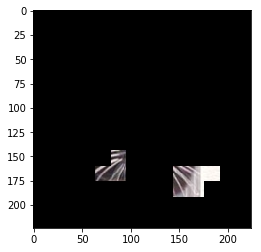

In [32]:
plt.imshow(a)

In [ ]:
dci.train()

In [ ]:
_,_,_ = dci.get_cam()

In [ ]:
dci.train()

In [ ]:
# dci.test_model_acc()

In [ ]:
md,dl = dci.return_model()

In [ ]:
a = iter(dl).next()

m = denorm_img(a['mask'],[0.223, 0.231, 0.243],[0.266, 0.270, 0.274]).squeeze()
bm = denorm_img(a['bmask'],[0.223, 0.231, 0.243],[0.266, 0.270, 0.274]).squeeze()

In [ ]:
device = torch.device("cuda:0")

p = F.sigmoid(md(a['image'].to(device))).detach().cpu().numpy().squeeze()

In [ ]:
m.shape

In [ ]:
p.shape

In [ ]:
bm.shape

In [ ]:
plt.imshow(bm)

In [ ]:
plt.imshow(m)

In [ ]:
p_m = p*bm
p_m[p_m > p_m.mean() + p_m.std()] = 1
p_m[p_m < p_m.mean() + p_m.std()] = 0

In [ ]:
plt.imshow(p_m)

In [ ]:
p_m_t = torch.Tensor(p_m)
print(nn.L1Loss()(torch.Tensor(p_m),torch.zeros(p_m_t.shape)))

In [ ]:
p*bm

In [ ]:
plt.imshow(p)